In [2]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [3]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
np.random.seed(91828)

In [5]:
def class_to_int(label , cl):
    temp = []
    for i in range(len(label)):
        #print(label[i])
        for j in range(len(cl)):
            if(label[i]==cl[j]):
                temp.append(j) 
    return temp
classes = ['BH' ,'NS' ]
ns_n = 0 
bh_n = 0


In [6]:

def get_xy(data):
    y = data['class']
    s = data['significance']
    info = data[['src_n' , 'src_id']]
    x = data.drop(columns=[ 'class' ,'src_n' ,'src_id' , 'significance'])
    #display(x)
    y_train_int = class_to_int(y, classes)
    one_hot_y_train =  to_categorical(y_train_int)
    global ns_n 
    global bh_n
    ns_n = float(y.value_counts()['NS']) 
    bh_n =  float(y.value_counts()['BH'])    
    print(ns_n , bh_n)
    return x , one_hot_y_train

In [7]:
def fit_model(model , x_train , one_hot_y_train , verbose=0 , validation=0.2):
    global ns_n 
    global bh_n 
    class_weight = {0: (ns_n/bh_n),
                    1: 1}
    history = model.fit(x_train, one_hot_y_train, batch_size=64, epochs=120, validation_split=validation, class_weight=class_weight, verbose=verbose )
    return history

In [8]:
def res_score(model , x , y ):
    y_prob = model.predict(x)
    y_pred = np.zeros_like(y_prob)
    y_pred[np.arange(len(y_prob)), y_prob.argmax(1)] = 1
    cf = np.matrix(np.matmul(y.T , y_pred))
    total = cf.sum()
    row_sum = cf.sum(axis=0)
    acc = np.trace(cf) / total 
    col_sum = cf.sum(axis=1) 
    #print(cf)
    return cf , acc


#_ , score = res_score(model , x , one_hot_y_train)
#print(score)

In [9]:
from tqdm import tqdm
def mc_validation(model_func , x , y , s=0.8 , model_name = '' , d_type = ''):
    from sklearn.model_selection import KFold
    kfold = KFold(8, True, 1)
    #k-fold cross-validation
    train_acc = []
    test_acc = []
    #s =  int(len(x)*s)
    x = np.array(x)
    y = np.array(y)
    index = np.arange(0,len(x))
    split_no = int(len(x)*s)
    print('split_no' , split_no)
    for i in tqdm(range(32)):
        np.random.shuffle(index)
        train_in ,test_in = index[:split_no] , index[split_no:]
        #print('-------------')
        #print(len(train_in ) , len(test_in))
        xtr  , ytr = x[train_in] , y[train_in]
        xtst , ytst = x[test_in] , y[test_in]
        model = model_func()
        fit_model(model , xtr , ytr , validation=0)
        _,train_acc_temp = res_score(model , xtr , ytr)
        _,test_acc_temp = res_score(model , xtst , ytst)
        train_acc.append(train_acc_temp)
        test_acc.append(test_acc_temp)
        print('-----------------------------------')
        print('training_acc :' , train_acc_temp)
        print('test_acc :' , test_acc_temp)
    acc_train =  pd.DataFrame()
    acc_test = pd.DataFrame()

    
    acc_test.insert(0 , 'acc_type' , ['Test_acc']*len(train_acc))
    acc_test.insert(1 , 'accuracy' , test_acc)
    acc_test = acc_test.reset_index(drop=True)
   
    acc_train.insert(0 , 'acc_type' , ['Train_acc']*len(train_acc))
    acc_train.insert(1 , 'accuracy' , train_acc)
    acc_train = acc_train.reset_index(drop=True)

    acc = pd.concat([acc_train , acc_test]).reset_index(drop=True)
    acc.insert(0 , 'model' , [model_name]*len(acc))
    acc.insert(1 , 'data_processing' , [d_type]*len(acc))
    return acc


In [9]:
!pwd

/home/shivam/thesis_aurora


## Load Data

In [11]:
data = pd.read_csv('processed_data/train_norm_corr_impute' , index_col=0).reset_index(drop=True)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
display(data.describe())
x_norm_corr , y_norm_corr = get_xy(data)

data = pd.read_csv('processed_data/train_norm_zero_impute' , index_col=0).reset_index(drop=True)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
display(data.describe())
x_norm_zero , y_norm_zero = get_xy(data) 

data = pd.read_csv('processed_data/train_norm_mean_impute' , index_col=0).reset_index(drop=True)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
display(data.describe())
x_norm_mean , y_norm_mean = get_xy(data)

data = pd.read_csv('processed_data/train_norm_median_impute' , index_col=0).reset_index(drop=True)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
display(data.describe())
x_norm_median , y_norm_median = get_xy(data)


,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,...,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,70.680500,0.428578,0.420357,0.433920,0.481062,0.504533,0.436517,0.434097,0.435983,0.465390,...,0.251453,0.259866,0.248030,0.612394,0.093594,0.852212,0.732214,0.689055,0.795208,0.659974
std,109.946267,0.198401,0.200715,0.182517,0.192136,0.185377,0.208229,0.164964,0.193531,0.195705,...,0.284852,0.291700,0.282629,0.284747,0.070030,0.415186,0.298392,0.279563,0.326928,0.229451
min,2.110000,0.000000,0.000000,-0.000767,0.000000,0.000000,-0.082395,0.000000,-0.029526,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.120000,0.286660,0.243411,0.302125,0.326932,0.365424,0.293230,0.298375,0.300438,0.304614,...,0.040732,0.045360,0.038345,0.452352,0.069422,0.608091,0.658813,0.618561,0.717195,0.654979
50%,23.470000,0.390999,0.430555,0.407365,0.502370,0.505772,0.426510,0.441569,0.409963,0.466873,...,0.052287,0.056642,0.050388,0.655933,0.090041,0.916857,0.758004,0.712205,0.825719,0.711883
75%,49.260000,0.561875,0.589274,0.553205,0.615238,0.627824,0.558226,0.569438,0.559324,0.600996,...,0.550404,0.569200,0.543390,0.814252,0.107216,1.151447,0.940119,0.882975,1.018479,0.785485
max,376.060000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.085012,1.000000,1.560725,1.111106,1.043694,1.209083,1.000000


302.0 158.0


,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,...,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,70.680500,0.405772,0.299390,0.412578,0.475729,0.497027,0.330700,0.073759,0.336558,0.396229,...,0.023443,0.022373,0.023921,0.010732,0.014849,0.006533,0.011490,0.012215,0.010280,0.012353
std,109.946267,0.221633,0.242112,0.202805,0.201697,0.194583,0.293861,0.183519,0.276541,0.268479,...,0.108967,0.105301,0.110320,0.085034,0.077365,0.052629,0.075177,0.080658,0.068562,0.059748
min,2.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.120000,0.270218,0.000000,0.286216,0.324350,0.358846,0.000000,0.000000,0.000000,0.175331,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,23.470000,0.381014,0.295346,0.402127,0.502370,0.504328,0.363721,0.000000,0.360282,0.437503,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49.260000,0.555333,0.531809,0.533815,0.615238,0.626640,0.549342,0.000000,0.552846,0.599765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,376.060000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


302.0 158.0


,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,...,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,70.680500,0.435094,0.411001,0.439062,0.488025,0.503648,0.486766,0.435076,0.469924,0.491760,...,0.404623,0.403553,0.405101,0.391912,0.399813,0.387714,0.392670,0.393395,0.394298,0.393533
std,109.946267,0.192867,0.166808,0.173418,0.184844,0.184688,0.162938,0.083531,0.163819,0.169472,...,0.120659,0.120791,0.120374,0.140097,0.117762,0.135550,0.132169,0.133299,0.128239,0.121356
min,2.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.120000,0.309677,0.297512,0.313406,0.358979,0.368118,0.435094,0.435094,0.391382,0.416628,...,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094
50%,23.470000,0.414513,0.435094,0.419350,0.502370,0.504328,0.435094,0.435094,0.435094,0.437503,...,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094
75%,49.260000,0.555333,0.531809,0.533815,0.615238,0.626640,0.549342,0.435094,0.552846,0.599765,...,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094
max,376.060000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


302.0 158.0


,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,...,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,70.680500,0.432186,0.399933,0.436436,0.486806,0.502991,0.471289,0.399244,0.456698,0.482287,...,0.366822,0.365752,0.367300,0.354110,0.361636,0.349912,0.354869,0.355594,0.356215,0.355732
std,109.946267,0.193170,0.166272,0.173786,0.185332,0.185008,0.169059,0.085081,0.167799,0.173541,...,0.111591,0.111370,0.111445,0.128678,0.106576,0.122419,0.120236,0.121704,0.116295,0.108540
min,2.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.120000,0.309677,0.297512,0.313406,0.358979,0.368118,0.391946,0.391946,0.391382,0.391946,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
50%,23.470000,0.391946,0.391946,0.402127,0.502370,0.504328,0.391946,0.391946,0.391946,0.437503,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
75%,49.260000,0.555333,0.531809,0.533815,0.615238,0.626640,0.549342,0.391946,0.552846,0.599765,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
max,376.060000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


302.0 158.0


# Convolution Neural Network

In [12]:
def gen_model_cnn():

    visible = layers.Input(shape=(92,1))
    x = layers.BatchNormalization(axis=-1)(visible)
    #x = tf.keras.layers.LeakyReLU(alpha=0.3)(visible)
    x = layers.Conv1D(32, kernel_size=3, activation='relu' , kernel_regularizer= 'l2', kernel_initializer='he_normal')(x)
    x = layers.MaxPool1D(pool_size=(2))(x)

    #x = layers.Conv1D(32, kernel_size=4, activation='relu' ,   kernel_regularizer= 'l2', kernel_initializer='he_normal')(x)
    #x = layers.MaxPool1D(pool_size=(2))(x)
    x = layers.Conv1D(16, kernel_size=3, activation='relu' , kernel_regularizer= 'l2', kernel_initializer='he_normal')(x)
    x = layers.MaxPooling1D(pool_size=(2))(x)
    #x = layers.Conv1D(32, kernel_size=4, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=(2))(x)
    x = layers.Flatten()(x)
    #x = layers.BatchNormalization(axis=-1)(x)
    x = layers.Dense(16, activation='relu' ,  kernel_regularizer= 'l2',kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(16, activation='relu')(x)
    output = layers.Dense(2, activation='softmax' , kernel_regularizer= 'l2' , kernel_initializer='he_normal')(x)
    model_cnn = keras.Model(inputs=visible, outputs=output)
    # summarize layers
    #print(model_cnn.summary())
    model_cnn.compile(
            loss = "categorical_crossentropy",
            optimizer = keras.optimizers.Adam(learning_rate=0.0005),
            metrics = ["accuracy"], 
        )
    
    return model_cnn


# Fully Connected network

In [13]:

def gen_model_fc():

    inputs =  keras.Input(shape=(92,))
    dense =  layers.Dense(32, activation='relu')
    x = dense(inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(2 , activation='softmax')(x)
    model = keras.Model(inputs=inputs , outputs=outputs , name='trial_model')
    model.compile(
        loss = "categorical_crossentropy",
        optimizer = keras.optimizers.Adam(learning_rate=0.0005),
        metrics = ["accuracy"],
    )
    return model


# Random Forest Classifier

In [ ]:
#acc_zero_cnn = mc_validation(gen_model_cnn , x_zero_mean , y_zero_mean , model_name = 'CNN' , d_type='Normalized')
#acc_mean_cnn = mc_validation(gen_model_cnn , x_norm_mean , y_norm_mean ,  model_name = 'CNN' , d_type = 'Standardized')
#acc_median_cnn = mc_validation(gen_model_cnn , x_norm_median , y_norm_median ,  model_name = 'CNN' , d_type = 'None')
acc_corr_cnn = mc_validation(gen_model_cnn , x_norm_corr , y_norm_corr ,  model_name = 'CNN' , d_type = 'Correlation')


#acc_zero_fc = mc_validation(gen_model_fc , x_zero_mean , y_zero_mean , model_name = 'fc' , d_type='Normalized')
#acc_mean_fc = mc_validation(gen_model_fc , x_norm_mean , y_norm_mean ,  model_name = 'fc' , d_type = 'Standardized')
#acc_median_fc = mc_validation(gen_model_fc , x_norm_median , y_norm_median ,  model_name = 'fc' , d_type = 'None')
acc_corr_fc = mc_validation(gen_model_fc , x_norm_corr , y_norm_corr ,  model_name = 'fc' , d_type = 'Correlation')


In [32]:
display(acc_std_fc)

,model,data_processing,acc_type,accuracy
0,FC,Standardized,Train_acc,1.000000
1,FC,Standardized,Train_acc,1.000000
2,FC,Standardized,Train_acc,1.000000
3,FC,Standardized,Train_acc,1.000000
4,FC,Standardized,Train_acc,1.000000
...,...,...,...,...
59,FC,Standardized,Test_acc,0.913043
60,FC,Standardized,Test_acc,0.836957
61,FC,Standardized,Test_acc,0.891304
62,FC,Standardized,Test_acc,0.847826


In [33]:
acc_norm_cnn = acc_norm_cnn.reset_index(drop=True)
acc_std_cnn =  acc_std_cnn.reset_index(drop=True)
acc_og_cnn =  acc_og_cnn.reset_index(drop=True)

acc_norm_fc = acc_norm_fc.reset_index(drop=True)
acc_std_fc =  acc_std_fc.reset_index(drop=True)
acc_og_fc =  acc_og_fc.reset_index(drop=True)

In [35]:
acc_data = pd.concat([acc_norm_cnn , acc_norm_fc , acc_std_cnn , acc_std_fc , acc_og_cnn , acc_og_fc]).reset_index(drop=True)
print(acc_data)

    model data_processing   acc_type  accuracy
0     CNN      Normalized  Train_acc  0.970109
1     CNN      Normalized  Train_acc  0.932065
2     CNN      Normalized  Train_acc  0.972826
3     CNN      Normalized  Train_acc  0.967391
4     CNN      Normalized  Train_acc  0.980978
..    ...             ...        ...       ...
379    FC            None   Test_acc  0.815217
380    FC            None   Test_acc  0.815217
381    FC            None   Test_acc  0.869565
382    FC            None   Test_acc  0.793478
383    FC            None   Test_acc  0.847826

[384 rows x 4 columns]


In [46]:
acc_data.to_csv('/content/drive/MyDrive/thesis_data/accuracy_result')

In [2]:
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
sns.catplot(data = acc_data , y='accuracy' , x = 'data_processing' ,
            hue= 'acc_type'  , kind='violin' ,split=True , 
            palette = 'crest' , height=6 , aspect=8/6
            )
#plt.savefig('/content/drive/MyDrive/thesis_data/acc_result_plot_violin.jpg')
plt.show()

NameError: name 'acc_data' is not defined

In [59]:
acc_temp = acc_data[acc_data['model']=='FC']
acc_temp = acc_temp[acc_temp['data_processing']=='Standardized']
acc_temp = acc_temp[acc_temp['acc_type']=='Test_acc']
display(acc_temp)

,model,data_processing,acc_type,accuracy
224,FC,Standardized,Test_acc,0.934783
225,FC,Standardized,Test_acc,0.891304
226,FC,Standardized,Test_acc,0.880435
227,FC,Standardized,Test_acc,0.880435
228,FC,Standardized,Test_acc,0.847826
229,FC,Standardized,Test_acc,0.902174
230,FC,Standardized,Test_acc,0.880435
231,FC,Standardized,Test_acc,0.815217
232,FC,Standardized,Test_acc,0.880435
233,FC,Standardized,Test_acc,0.945652


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


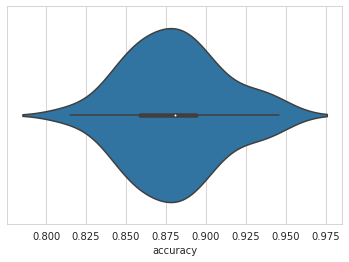

In [62]:
sns.violinplot(acc_temp['accuracy'])
plt.show()

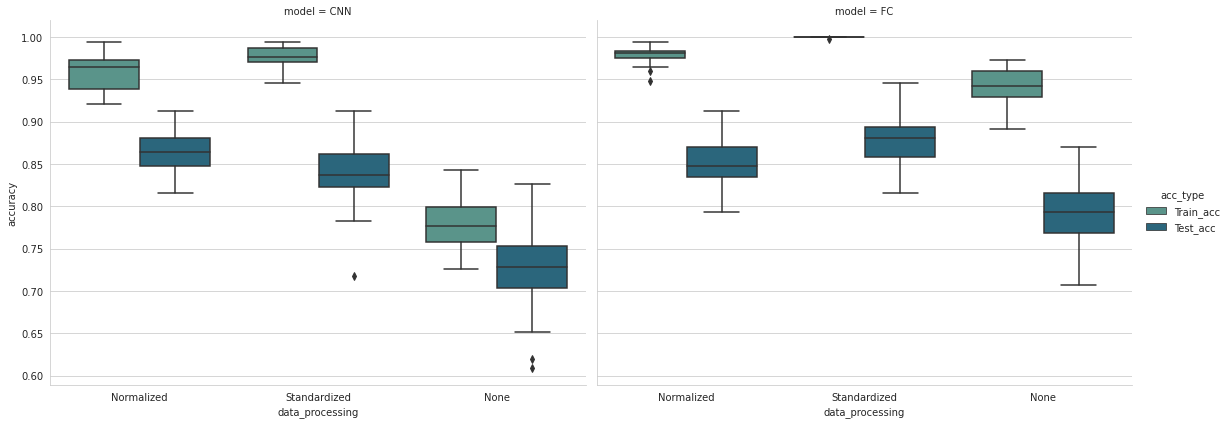

In [53]:
sns.set_style('whitegrid')
sns.catplot(data = acc_data , y='accuracy' , x = 'data_processing' ,
            hue= 'acc_type' , col = 'model' , kind='box' ,
            palette = 'crest' , height=6 , aspect=8/6
            )
plt.savefig('/content/drive/MyDrive/thesis_data/acc_result_plot_box.jpg')
plt.show()

In [75]:
acc_data_fc = pd.concat([acc_norm_fc , acc_std_fc , acc_og_fc]).reset_index(drop=True)

In [ ]:
acc_data_cnn = pd.concat([acc_norm_cnn , acc_std_cnn , acc_og_cnn]).reset_index(drop=True)

In [66]:
display(acc_data_cnn)

,data_processing,model,train_acc,test_acc
0,Normalized,CNN,0.972826,0.880435
1,Normalized,CNN,0.921196,0.891304
2,Normalized,CNN,0.959239,0.847826
3,Normalized,CNN,0.967391,0.913043
4,Normalized,CNN,0.945652,0.880435
...,...,...,...,...
91,None,CNN,0.967391,0.880435
92,None,CNN,0.959239,0.836957
93,None,CNN,0.980978,0.793478
94,None,CNN,0.948370,0.847826
